This is a notebook that analyzes the files created to describe the dataset before the quality control step.

The files were created using commands:

1. Data description -> General distribution of depth, missingness, heterozygosity (.vchk file output)
bcftools stats joint.hg38.vcf.gz > joint.hg38.vchk

2. Generate a summary of the number of SNPs and Ts/Tv ratio for each FILTER category. (.FILTER.summary file output)
vcftools --gzvcf joint.hg38.vcf.gz --FILTER-summary --out joint.hg38.PRE-QC
 
3. Site missingness -> Generate a file reporting the missingness on a per-site basis. (.lmiss file output)
vcftools --gzvcf joint.hg38.vcf.gz --missing-site --out joint.hg38.PRE-QC

4. Individual missingness -> Generate a file reporting the missingness on a per-individual basis.(.imiss file output)
vcftools --gzvcf joint.hg38.vcf.gz --missing-indv --out joint.hg38.PRE-QC

5. Site depth -> Generate a file containing the mean depth per site across all individuals. (ldepth.mean file output)
vcftools --gzvcf joint.hg38.vcf.gz --site-mean-depth --out joint.hg38.PRE-QC 

6. Individual depth -> Generate a file containing the mean depth per individual. (.idepth file output)
vcftools --gzvcf joint.hg38.vcf.gz --depth --out joint.hg38.PRE-QC

7. Individual heterozygosity (.het file output)
vcftools --gzvcf joint.hg38.vcf.gz --het --out joint.hg38.PRE-QC

bcftools version: 1.9-94-g9589876
vcftools version: 0.1.15

Short summary of what we expect to learn from each file

1. vchk : stats by non-reference allele frequency, depth distribution, stats by quality and per-sample counts, singleton stats, etc. are included in this file

2. FILTER.summary : Generates a summary of the number of SNPs and Ts/Tv ratio for each FILTER category

3. lmiss : reports the missingness on a per-site basis

4. imiss : reports the missingness on a per-individual basis

5. ldepth.mean : contains the mean depth per site averaged across all individuals

6. idepth : contains the mean depth per individual

7. het : Calculates a measure of heterozygosity on a per-individual basis. Specfically, the inbreeding coefficient, F, is estimated for each individual using a method of moments

In [1]:
# Import relevant libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
import os

In [3]:
# Read in the vchk file produced by bcftools and divide it into separate parts
# Summary numbers, Stats by non-reference allele frequency, Stats by quality,
# Indel distribution, Depth distribution

name = 'joint_colombia_annotated'
notebook_path = os.path.abspath("preQC_general_analysis.ipynb")
vchk_file_path = os.path.join(os.path.dirname(notebook_path), 'data/'+name + ".hg38.vchk")

### 1. Summary numbers
# Shows us vary quick overview of the data
# SN [2]id [3]key [4]value
with open(vchk_file_path, 'r') as f:
    for line in f:
        if line.startswith('SN'):
            print(' '.join(line.strip().split('\t')[2:]))

number of samples: 1025
number of records: 50492088
number of no-ALTs: 0
number of SNPs: 44170352
number of MNPs: 0
number of indels: 6864394
number of others: 0
number of multiallelic sites: 4426295
number of multiallelic SNP sites: 430868


In [4]:
### 2. Stats by non-reference allele frequency
#AF [2]id [3]allele frequency [4]number of SNPs [5]number of transitions [6]number of transversions [7]number of indels [8]repeat-consistent [9]repeat-inconsistent [10]not applicable
# Collect the data
allele_freq_data = {}
with open(vchk_file_path, 'r') as f:
    for line in f:
        if line.startswith('AF'):
            line = line.split('\t')
            freq, snp_n, transitions_n, transversions_n, indels_n = float(line[2]), int(line[3]), int(line[4]), int(line[5]), int(line[6])
            rep_cons, rep_incons = int(line[7]), int(line[8])
            allele_freq_data[freq] = [snp_n, transitions_n, transversions_n, indels_n, rep_cons, rep_incons]
            
# Make a dataframe
cols = ['snp_n', 'transitions_n', 'transversions_n', 'indels_n', 'rep_cons', 'rep_incons']
freq_df = pd.DataFrame.from_dict(allele_freq_data, orient='index', columns=cols)
freq_df = freq_df.reset_index()
freq_df.head()

,index,snp_n,transitions_n,transversions_n,indels_n,rep_cons,rep_incons
0,0.000000,13516987,8991132,4525855,1790271,0,0
1,0.000976,6654367,4346432,2307935,1250107,0,0
2,0.001951,3356348,2159123,1197225,743869,0,0
3,0.002927,2149873,1371923,777950,532493,0,0
4,0.003902,1546336,982106,564230,416641,0,0


Text(0.5, 1.0, 'SNP numbers across different allele frequencies in the dataset')

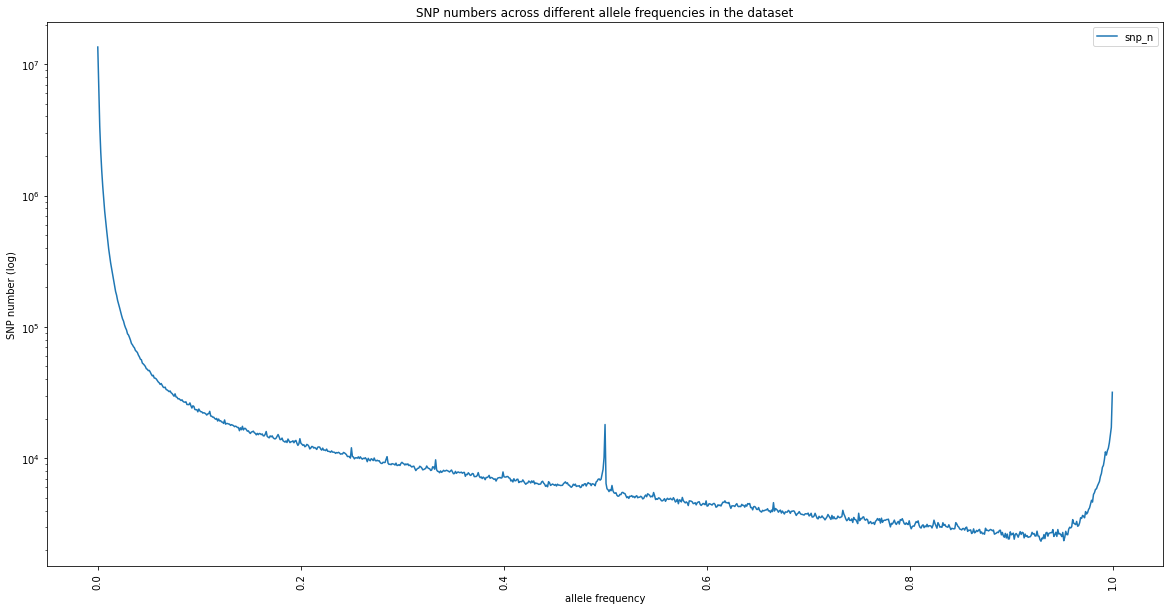

In [5]:
# SNP count at each frequency
plt.rcParams["figure.figsize"] = (20,10)
freq_df.plot(x='index', y='snp_n')
plt.xticks(rotation=90)
plt.yscale('log')
plt.xlabel('allele frequency')
plt.ylabel('SNP number (log)')
plt.title('SNP numbers across different allele frequencies in the dataset')

Text(0.5, 1.0, 'Indel numbers across different allele frequencies in the dataset')

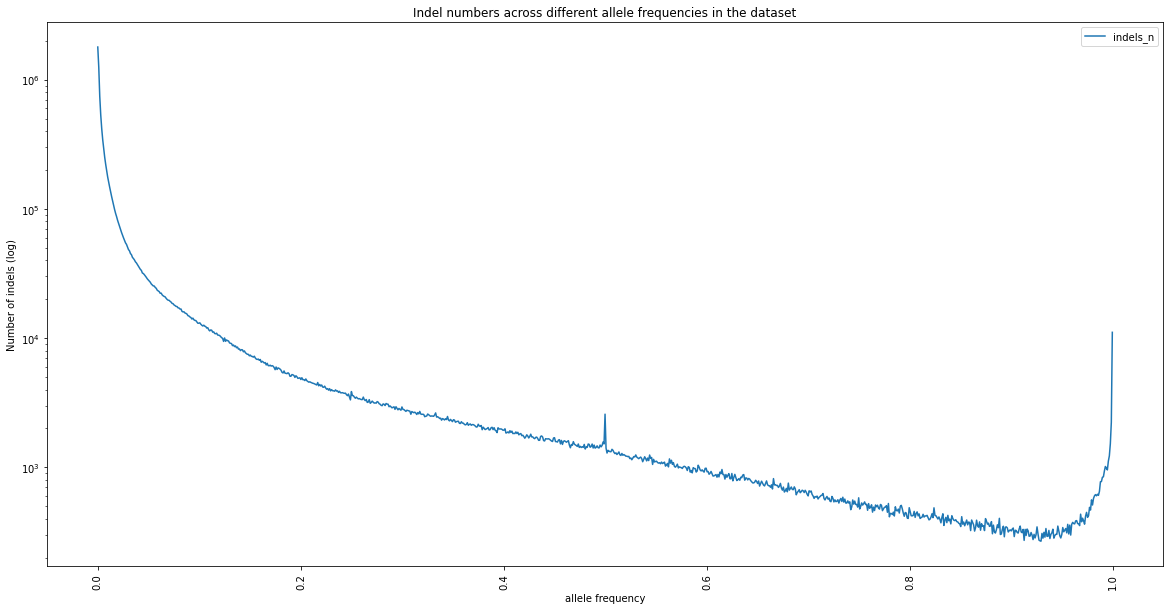

In [5]:
plt.rcParams["figure.figsize"] = (20,10)
freq_df.plot(x='index', y='indels_n')
plt.xticks(rotation=90)
plt.yscale('log')
plt.xlabel('allele frequency')
plt.ylabel('Number of indels (log)')
plt.title('Indel numbers across different allele frequencies in the dataset')

In [6]:
### 3. Stats by quality

# The QUAL value reflects how confident we are that a site displays some kind of variation considering 
# the amount of data available (=depth of coverage at the site) (because we are more confident when we
# have more observations to rely on), the quality of the mapping of the reads and alignment of the bases 
# (because if we are not sure the bases observed really belong there, they do not contribute much to our 
# confidence), and the quality of the base calls (because if they look like machine errors, they also do 
# not contribute much to our confidence).

# QUAL [2]id [3]Quality [4]number of SNPs [5]number of transitions (1st ALT) [6]number of transversions (1st ALT) [7]number of indels
quality_freq_data = {}
with open(vchk_file_path, 'r') as f:
    for line in f:
        if line.startswith('QUAL'):
            line = line.split('\t')
            qual, snp_n, transitions_n, transversions_n, indels_n = float(line[2]), int(line[3]), int(line[4]), int(line[5]), int(line[6])
            quality_freq_data[qual] = [snp_n, transitions_n, transversions_n, indels_n]
            
# Make a dataframe
cols = ['snp_n', 'transitions_n', 'transversions_n', 'indels_n']
qual_df = pd.DataFrame.from_dict(quality_freq_data, orient='index', columns=cols)
qual_df = qual_df.reset_index()
qual_df.head()

,index,snp_n,transitions_n,transversions_n,indels_n
0,30.0,36231,17807,18424,4935
1,31.0,25912,12039,13873,2493
2,32.0,24179,10984,13195,2613
3,33.0,40117,20096,20021,5322
4,34.0,31342,14248,17094,2494


Text(0.5, 1.0, 'SNP numbers across different qualities in the dataset')

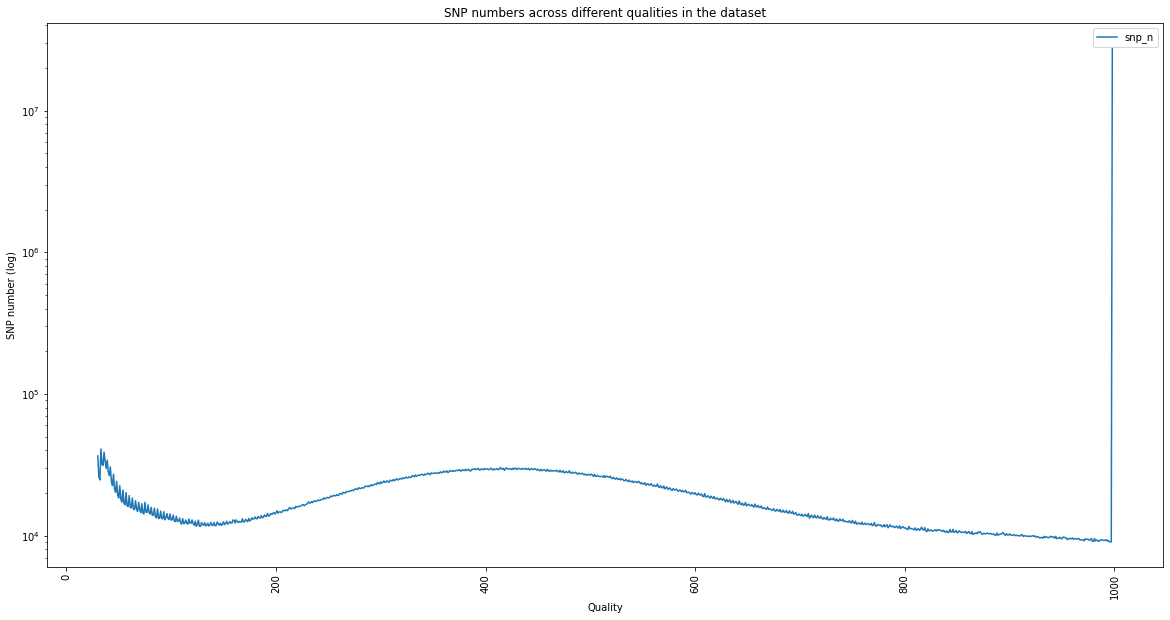

In [36]:
# SNP count at each quality
plt.rcParams["figure.figsize"] = (20,10)
qual_df.plot(x='index', y='snp_n')
plt.xticks(rotation=90)
plt.yscale('log')
plt.xlabel('Quality')
plt.ylabel('SNP number (log)')
plt.title('SNP numbers across different qualities in the dataset')

Text(0.5, 1.0, 'Indel numbers across different qualities in the dataset')

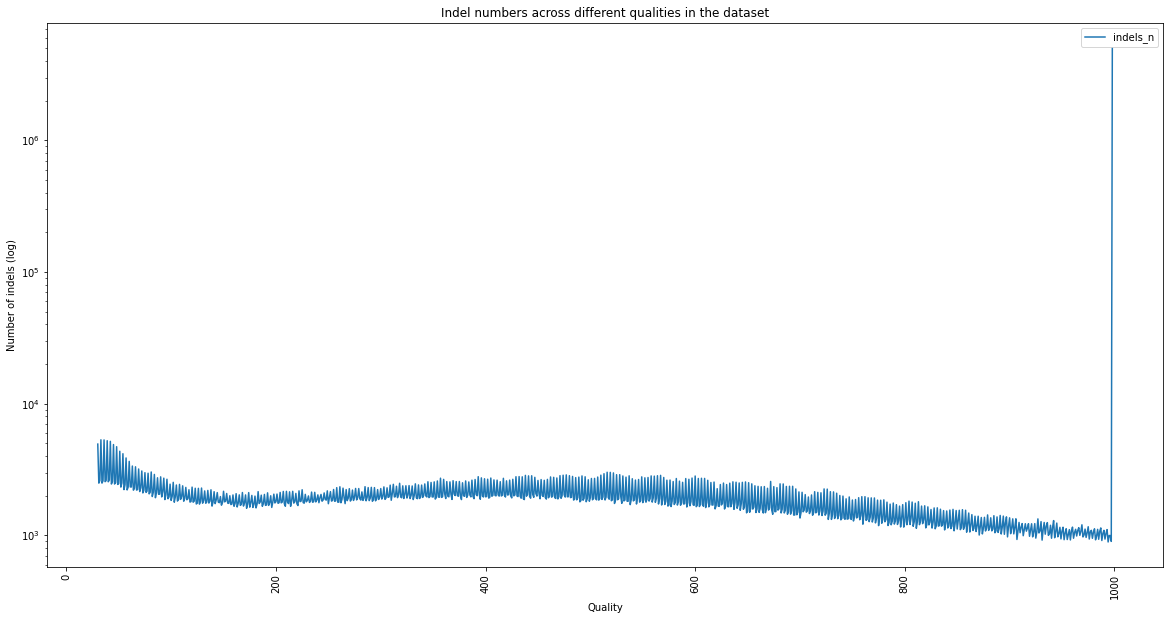

In [7]:
plt.rcParams["figure.figsize"] = (20,10)
qual_df.plot(x='index', y='indels_n')
plt.xticks(rotation=90)
plt.yscale('log')
plt.xlabel('Quality')
plt.ylabel('Number of indels (log)')
plt.title('Indel numbers across different qualities in the dataset')

Text(0.5, 1.0, 'Indel numbers across different Indel lengths in the dataset')

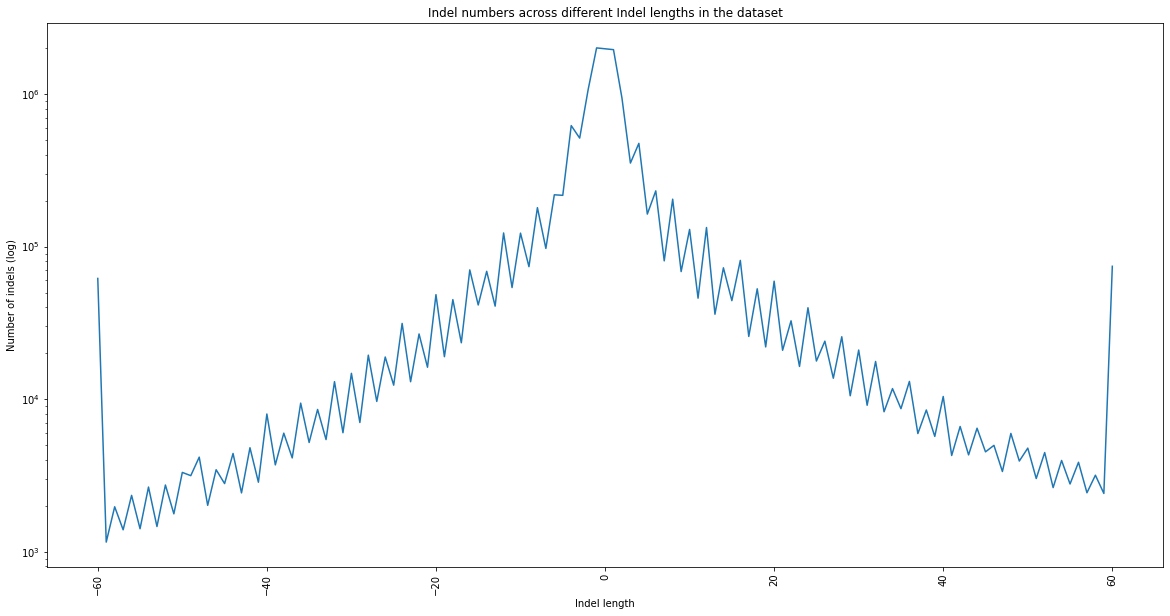

In [8]:
### 4. Indel distribution

# Length of the indels can be positive (insertions) or negative (deletions) (in  bp?)

# IDD [2]id [3]length  [4]count
indel_freq_data = {}
with open(vchk_file_path, 'r') as f:
    for line in f:
        if line.startswith('IDD'):
            line = line.split('\t')
            length, count= float(line[2]), int(line[3])
            indel_freq_data[length] = count

# Plot the Indel frequency per length
lengths = list(indel_freq_data.keys())
counts = list(indel_freq_data.values())
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(lengths, counts)
plt.xticks(rotation=90)
plt.yscale('log')
plt.xlabel('Indel length')
plt.ylabel('Number of indels (log)')
plt.title('Indel numbers across different Indel lengths in the dataset')      

In [9]:
### 5. Depth distribution
# DP [2]id [3]bin [4]number of genotypes [5]fraction of genotypes (%) [6]number of sites [7]fraction of sites (%)
# In this particular dataset, 2, 4,  and 5 don't have any info (all 0s) 
depth_freq_data = {}
with open(vchk_file_path, 'r') as f:
    for line in f:
        if line.startswith('DP'):
            line = line.split('\t')
            if line[2] == '>500':
                depth, site_n, fraction = 501, int(line[5]), float(line[6])
            else:
                depth, site_n, fraction = int(line[2]), int(line[5]), float(line[6])
            depth_freq_data[depth] = [site_n, fraction]

# Make a dataframe
cols = ['site_n', 'fraction']
depth_df = pd.DataFrame.from_dict(depth_freq_data, orient='index', columns=cols)
depth_df = depth_df.reset_index()
depth_df.head()


,index,site_n,fraction
0,1,1,0.000002
1,2,191,0.000378
2,3,196,0.000388
3,4,312,0.000618
4,5,321,0.000636


Text(0.5, 1.0, 'Number of sites across different depths in the dataset')

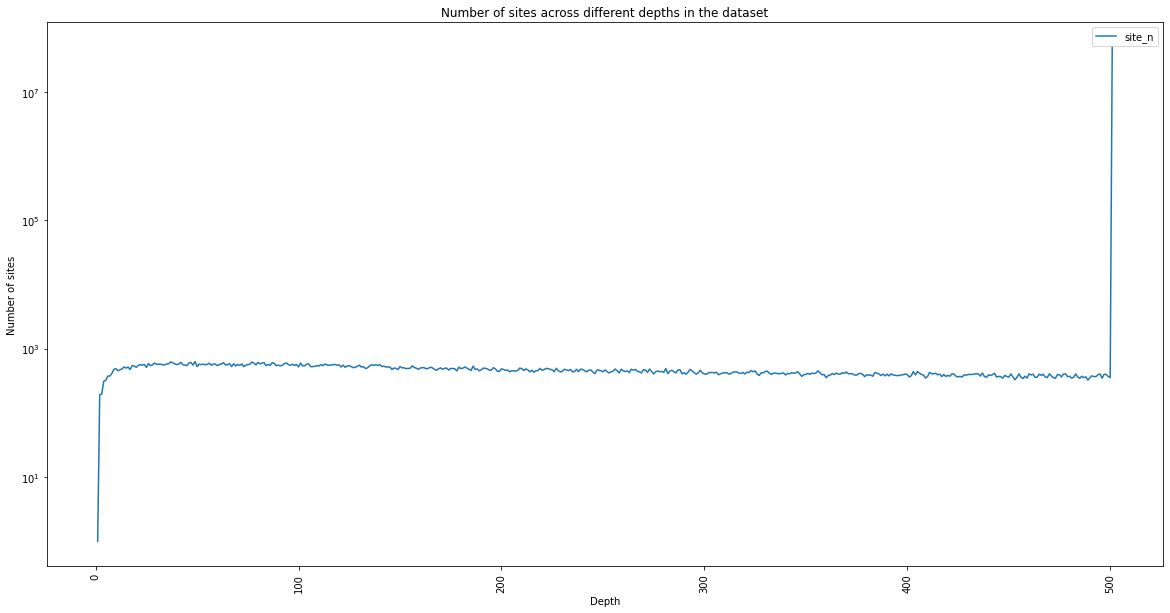

In [10]:
# Plot the depth frequency 
plt.rcParams["figure.figsize"] = (20,10)
depth_df.plot(x='index', y='site_n')
plt.xticks(rotation=90)
plt.yscale('log')
plt.xlabel('Depth')
plt.ylabel('Number of sites')
plt.title('Number of sites across different depths in the dataset')

In [24]:
# Use the .PRE-QC.FILTER.summary file to check the general description of the filters

filter_file_path = os.path.join(os.path.dirname(notebook_path), "data/" + name + ".PRE-QC.FILTER.summary")

columns=['N_VARIANTS', 'N_Ts','N_Tv','Ts/Tv']
filter_dict = {}
with open(filter_file_path, 'r') as f:
    f.readline()   # skip header
    for line in f:
        f, n_var, n_ts, n_tv, ts_tv = line.strip().split('\t')
        filter_dict[f] = [int(n_var), int(n_ts), int(n_tv), float(ts_tv)]
        
filter_df = pd.DataFrame.from_dict(filter_dict, orient='index', columns=columns)
#depth_df = depth_df.reset_index()
filter_df.head()

,N_VARIANTS,N_Ts,N_Tv,Ts/Tv
PASS,39871929,23294994,10943368,2.128690
VQSRTrancheSNP99.00to99.90,4836193,2970366,1865827,1.591980
VQSRTrancheSNP99.90to100.00,4529661,2194277,2335384,0.939579
VQSRTrancheINDEL99.00to99.90,959507,15015,12966,1.158030
VQSRTrancheINDEL99.90to100.00,294798,4118,4680,0.879915


In [7]:
# Check the mean depth per chromosome using ldepth.mean file
# Does each chromosome have similar mean depth or is there a variation? 
# Are there regions in each chromosomes that have smaller mean depth than other?


notebook_path = os.path.abspath("preQC_general_analysis.ipynb")
depth_file_path = os.path.join(os.path.dirname(notebook_path), "data/" + name + ".PRE-QC.ldepth.mean")

# Read the mean depth file and divide the info into chromosomes.
per_chr_depth = {}
with open(depth_file_path, 'r') as f:
    f.readline()  # skip header
    for line in f:
        ch, depth = line.split('\t')[0][3:], float(line.split('\t')[2])
        if ch not in per_chr_depth.keys():
            print(ch)
            per_chr_depth[ch] = [depth]
        else:
            per_chr_depth[ch].append(depth)
        

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
X
Y


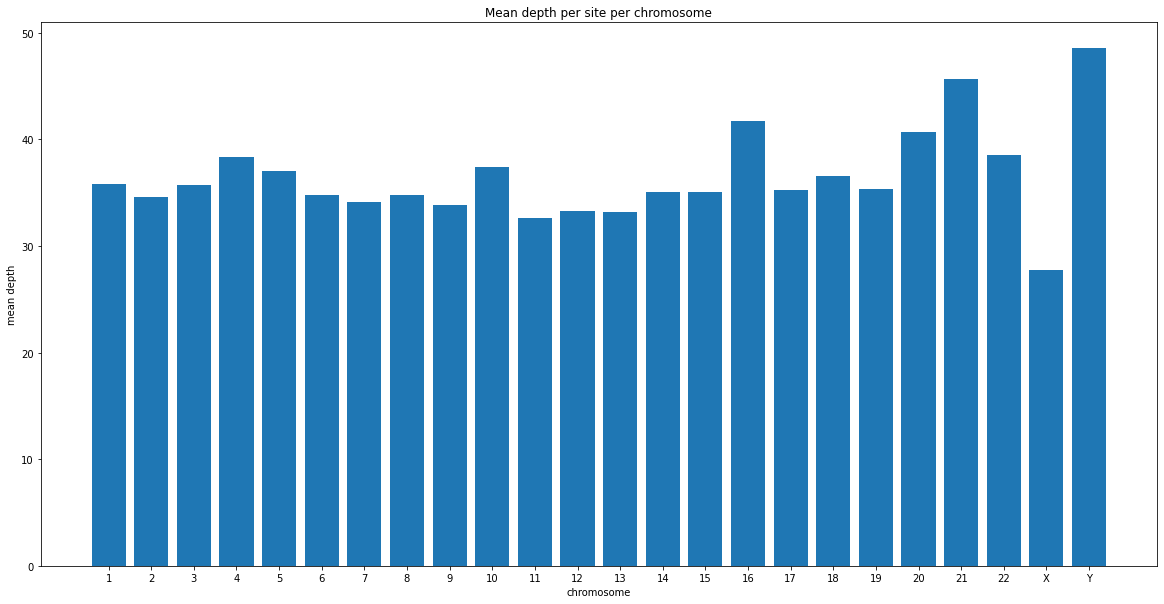

In [12]:
# Plot the mean depth of each chromosome 
plt.bar(list (per_chr_depth.keys()),[np.mean(per_chr_depth[i]) for i in per_chr_depth.keys()])
plt.title('Mean depth per site per chromosome')
plt.xlabel('chromosome')
plt.ylabel('mean depth')
plt.show()

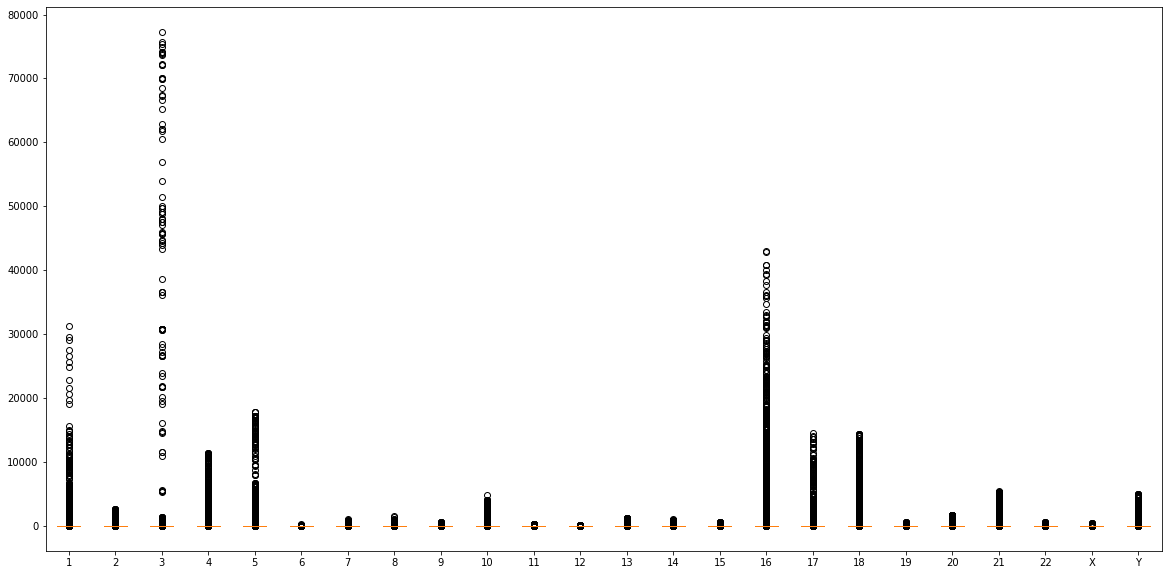

In [8]:
# Plot a box plot of the mean depths per chromosome

labels, data = [*zip(*per_chr_depth.items())]  # 'transpose' items to parallel key, value lists

plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.xlabel('chromosome')
plt.ylabel('mean depth')
plt.show()

In [13]:
# There's a lot of variation in the mean depth per site. What's the distribution of those mean depths per chromosome? 
# How much do they actually vary?

def make_cummulant(depths):

    # Show a cumulant graph for the distribution of mean depth values
    bins = np.arange(0, 101, 1)      # there are some big outliers but most of the distribution is around 0 - 70 mean depth
    depth_values, bins, _ = plt.hist(depths, bins=bins)


    # Calculate the cumulant for BLAST noref identities
    depth_total = float(sum(depth_values))

    depth_values_fractions = [0.0]
    current_total = 0.0
    for i in depth_values:
        current_total += (i/depth_total)
        depth_values_fractions.append(current_total)

    return(bins, depth_values_fractions)
    

In [14]:
def make_4_cummulant_graphs(chromosomes):
    """
    Given 4 chromosome labels, create a graph with 4 panels that show
    the distribution of the mean depth scores.
    """
    # Show a cumulant graph for the distribution of identity scores
    bins1, fractions1 = make_cummulant(per_chr_depth[chromosomes[0]])
    bins2, fractions2 = make_cummulant(per_chr_depth[chromosomes[1]])
    bins3, fractions3 = make_cummulant(per_chr_depth[chromosomes[2]])
    bins4, fractions4 = make_cummulant(per_chr_depth[chromosomes[3]])

    plt.clf()
    fig = plt.figure()
    gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
    (ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')

    ax1.plot(bins1, fractions1, label='chr '+chromosomes[0], color='blue')
    ax2.plot(bins2, fractions2, label='chr '+chromosomes[1], color='red')
    ax3.plot(bins3, fractions3, label='chr '+chromosomes[2], color='magenta')
    ax4.plot(bins4, fractions4, label='chr '+chromosomes[3], color='green')

    #plt.plot(bins, fractions)
    ax3.set_xlabel('mean depth')
    ax3.set_ylabel('fraction of sites')
    fig.legend()
    fig.suptitle('What is the distribution of mean depth values for different chromosomes?')
    plt.show()

<Figure size 1440x720 with 0 Axes>

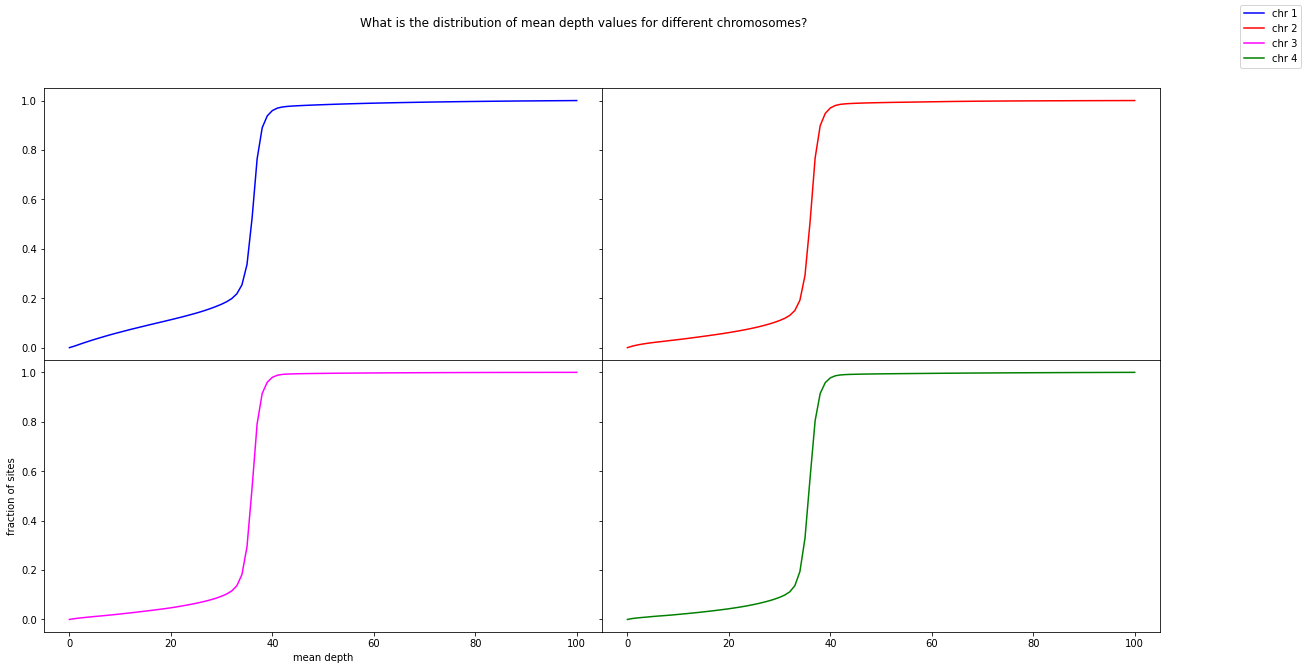

<Figure size 1440x720 with 0 Axes>

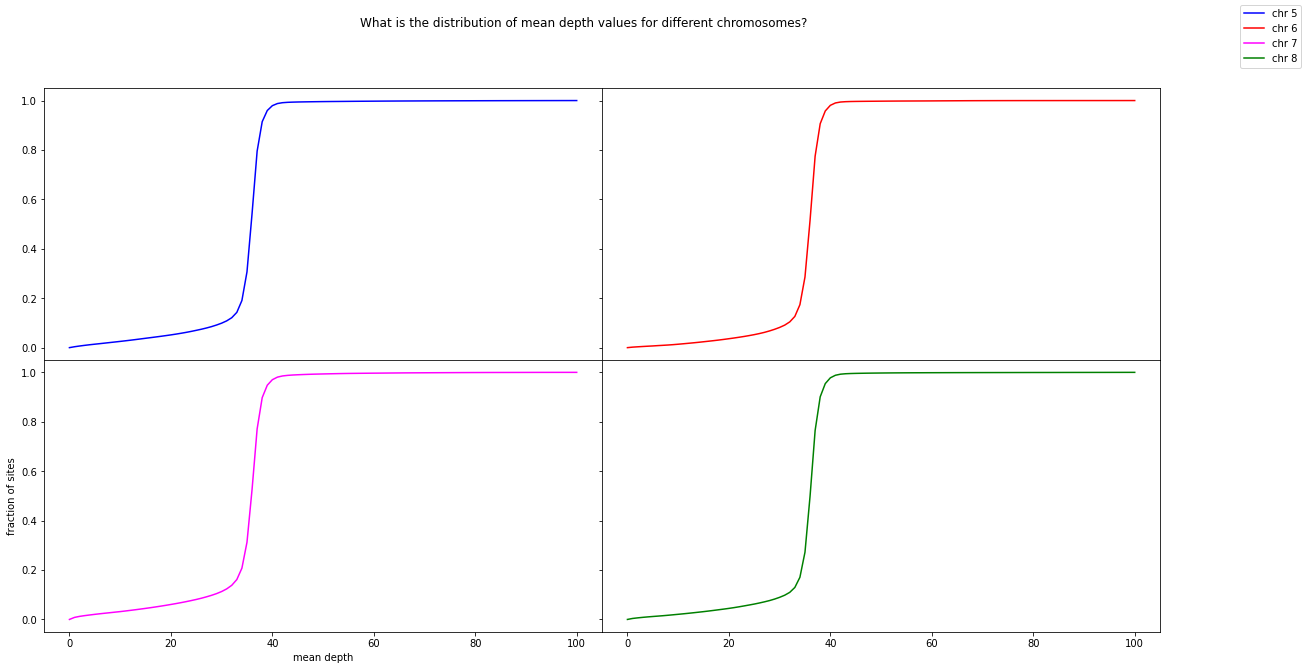

<Figure size 1440x720 with 0 Axes>

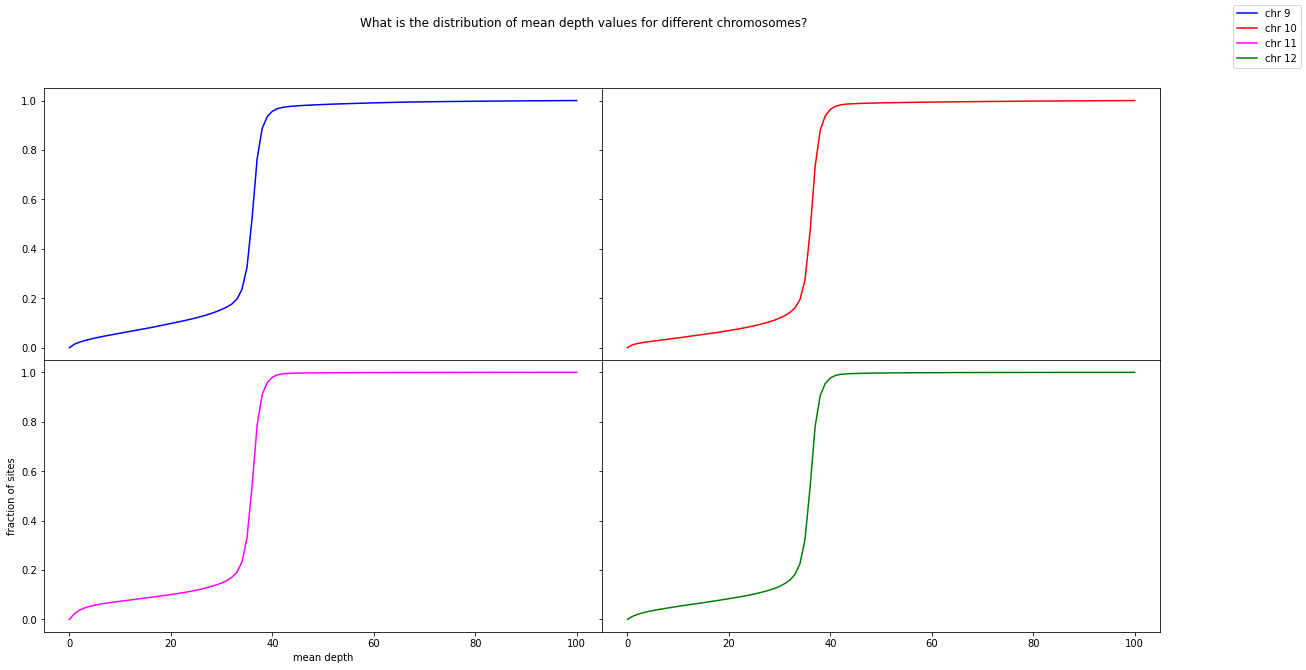

<Figure size 1440x720 with 0 Axes>

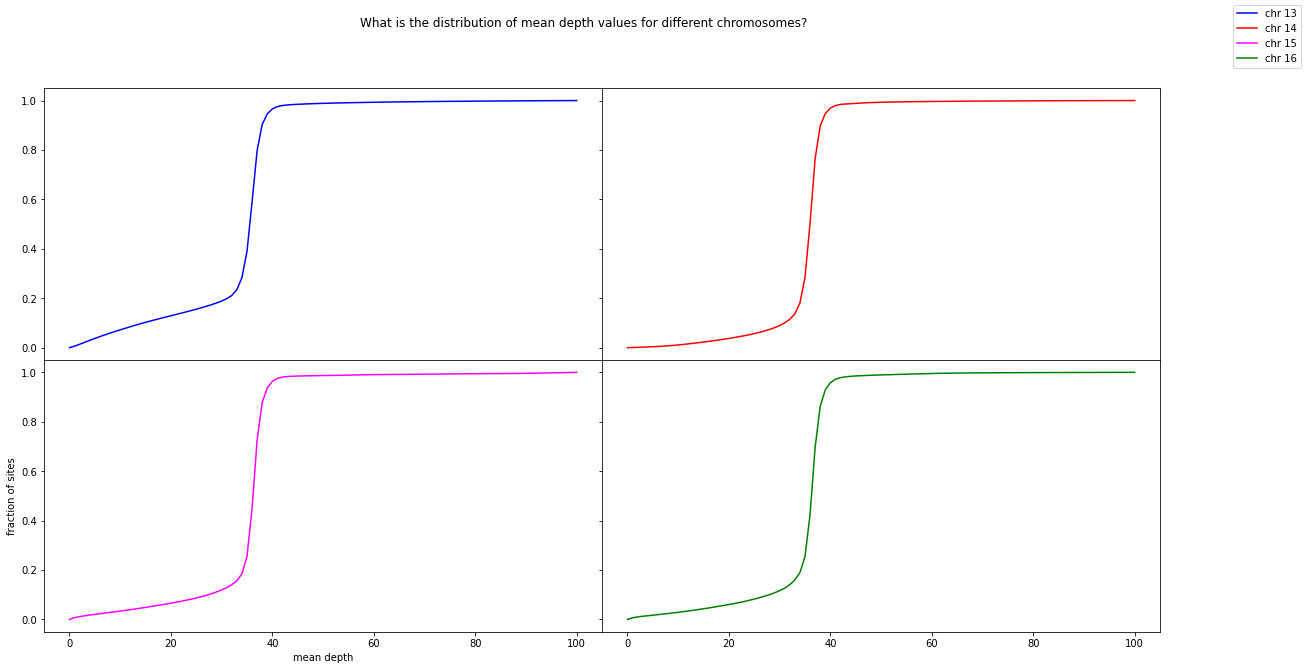

<Figure size 1440x720 with 0 Axes>

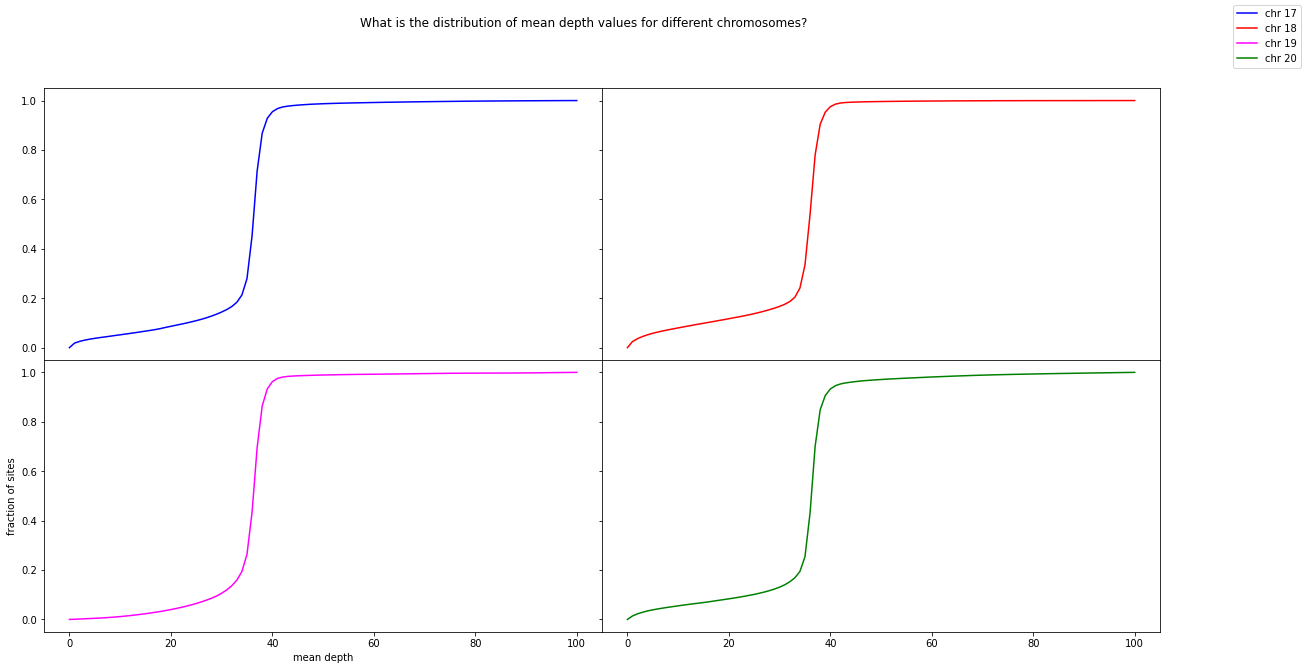

<Figure size 1440x720 with 0 Axes>

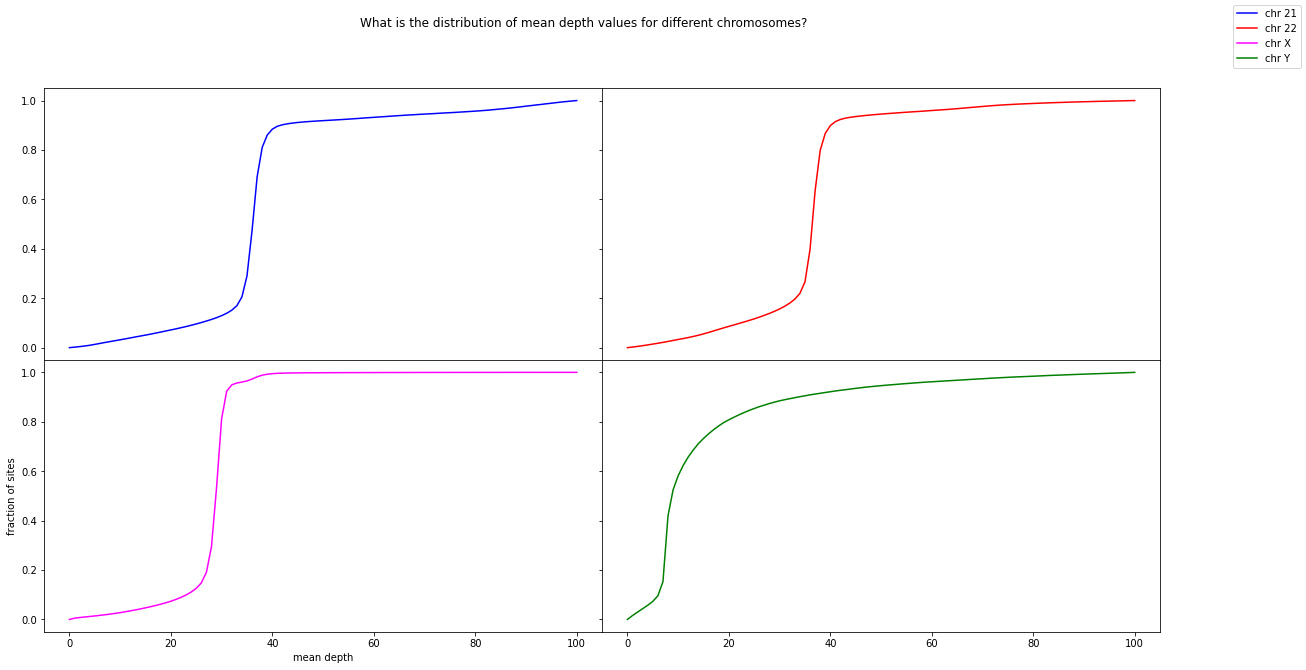

In [15]:
# Show a cumulant graph for the distribution of identity scores
make_4_cummulant_graphs(['1', '2', '3', '4'])
make_4_cummulant_graphs(['5', '6', '7', '8'])
make_4_cummulant_graphs(['9', '10', '11', '12'])
make_4_cummulant_graphs(['13', '14', '15', '16'])
make_4_cummulant_graphs(['17', '18', '19', '20'])
make_4_cummulant_graphs(['21', '22', 'X', 'Y'])

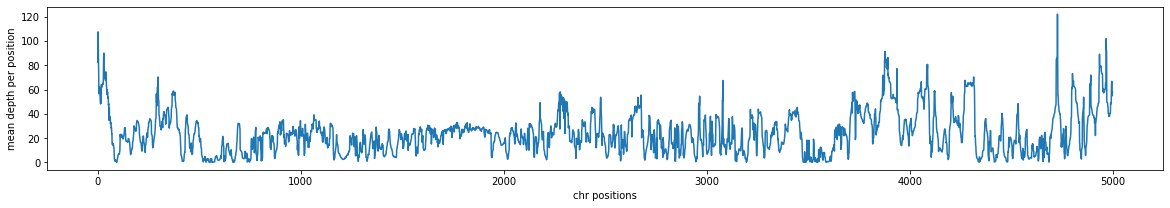

In [16]:
# What is the mean depth for the consecutive positions in the chromosome?

dist_range = [0,5000] # position range we want to plot (start, end)

plt.rcParams["figure.figsize"] = (20,3)
plt.plot(range(dist_range[0],dist_range[1]), per_chr_depth['1'][dist_range[0]:dist_range[1]])
plt.ylabel('mean depth per position')
plt.xlabel('chr positions')
plt.show()


In [17]:
# What is the number of bases that are covered above a particular depth? 

depths = [10, 15, 20, 25, 30, 35, 40]
chromosomes = list(per_chr_depth.keys())

# For each chromosome, calculate the number of sites that have a depth above the set threshold
# Calculate a percentage of sites per chromosome
sites_per_chr_per_depth = {}
for chr in chromosomes:
    chr_depths = np.array(per_chr_depth[chr])
    total = float(len(chr_depths))
    for d in depths:
        good_sites = sum(chr_depths >= d)
        if chr not in sites_per_chr_per_depth.keys():
            sites_per_chr_per_depth[chr] = {d: good_sites/total}
        else:
            sites_per_chr_per_depth[chr][d] = good_sites/total
            

KeyboardInterrupt: 

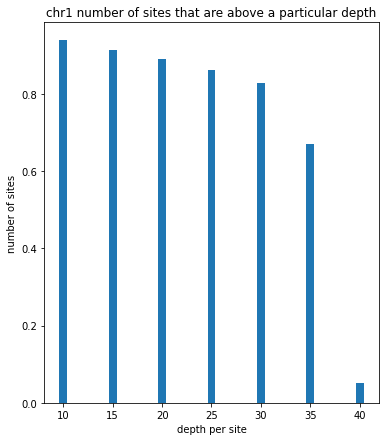

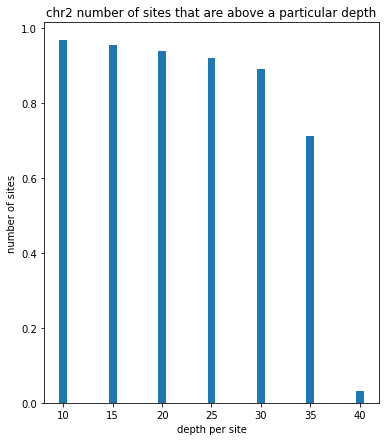

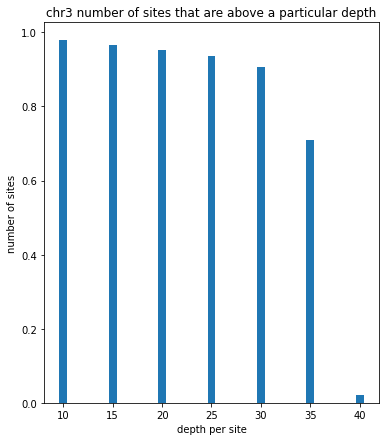

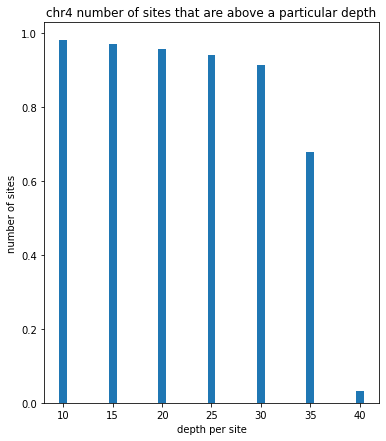

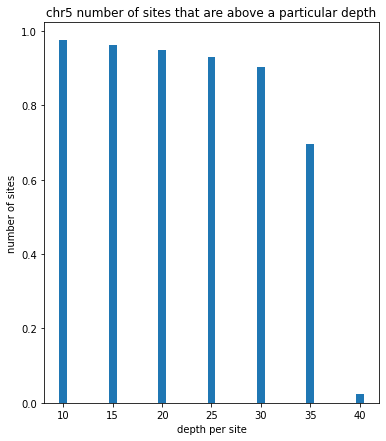

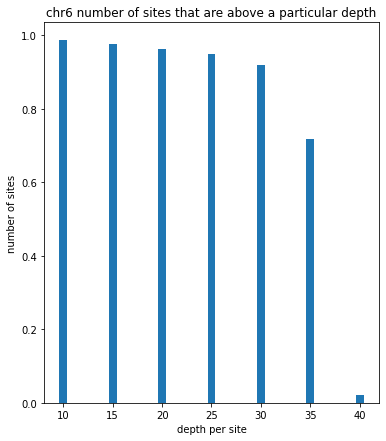

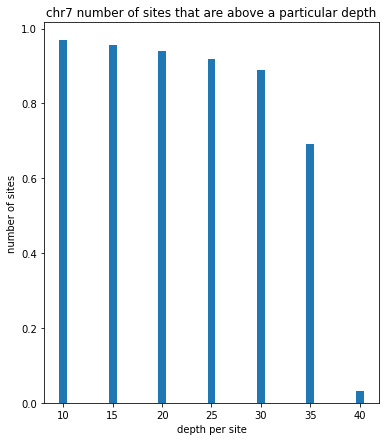

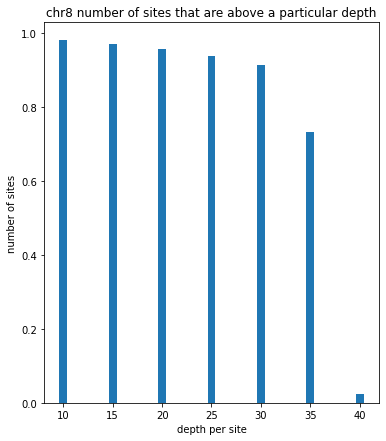

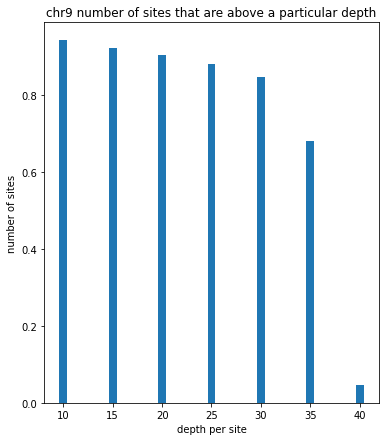

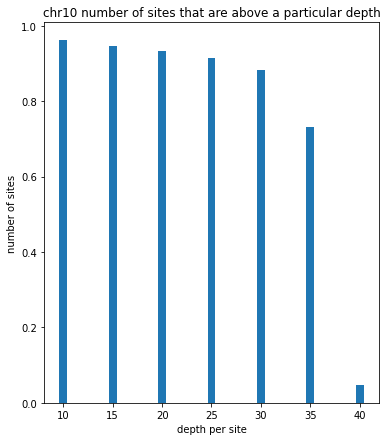

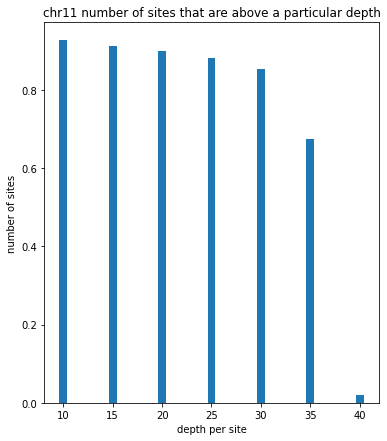

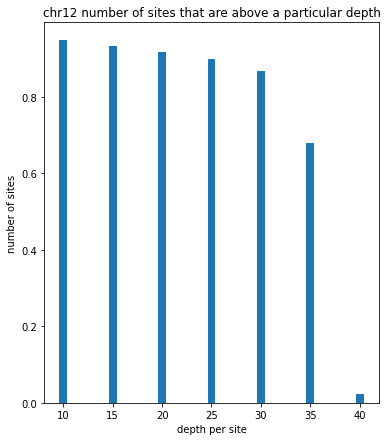

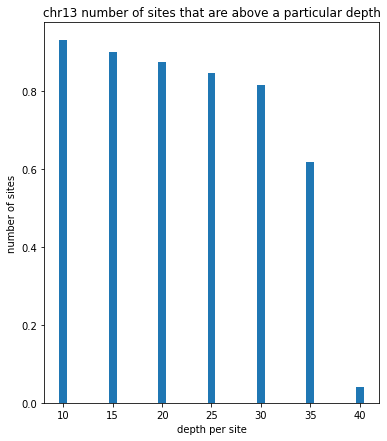

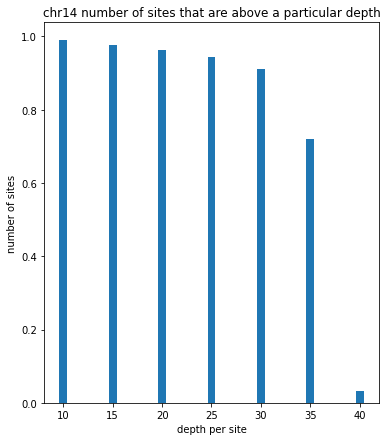

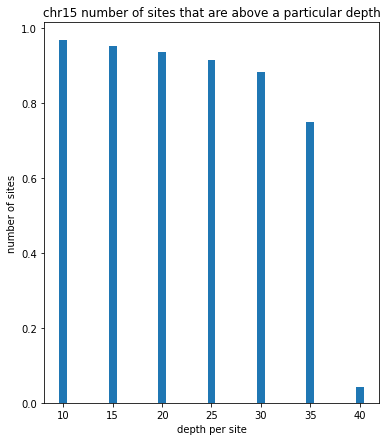

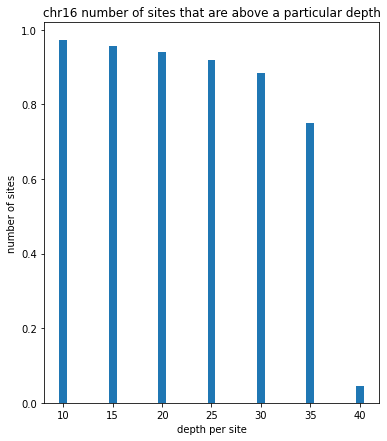

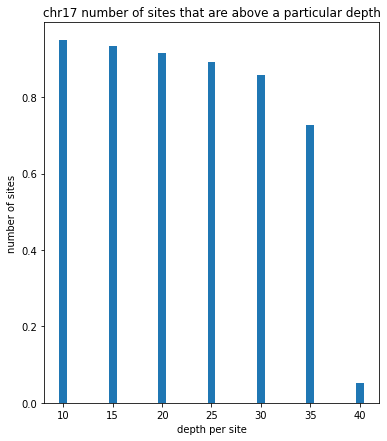

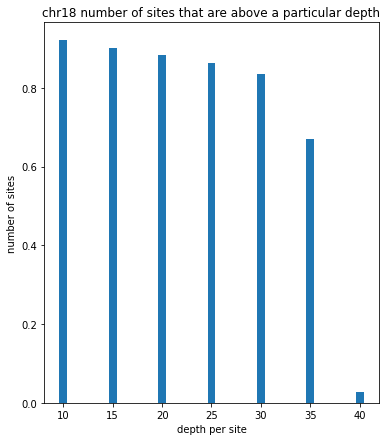

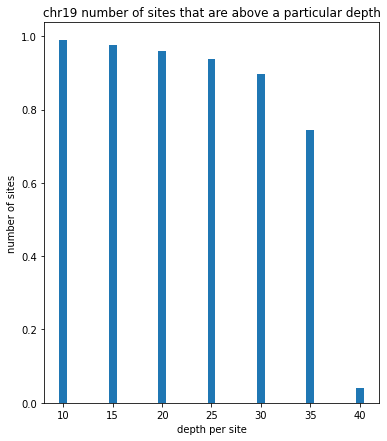

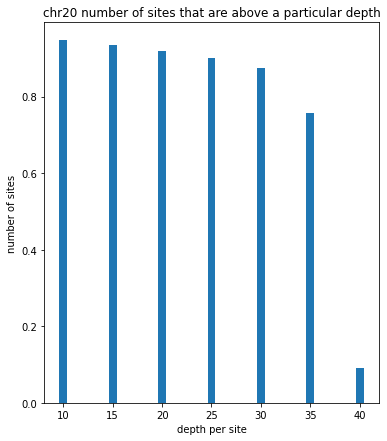

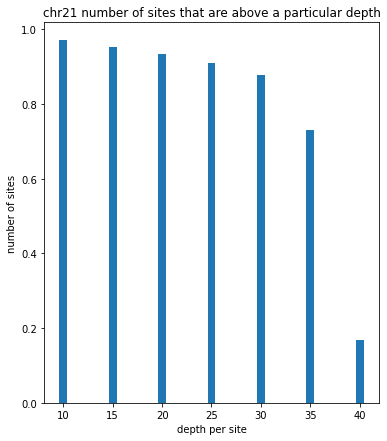

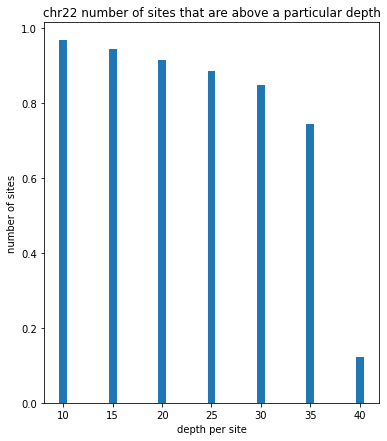

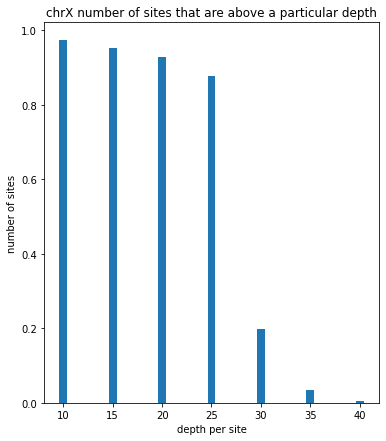

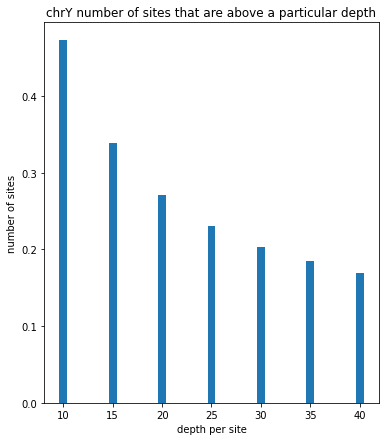

In [41]:
# Plot each chromosome separately
plt.rcParams["figure.figsize"] = (6,6)

for chr in chromosomes:
    depths = sites_per_chr_per_depth[chr]
    plt.bar(depths.keys(), depths.values())
    plt.ylabel('number of sites')
    plt.xlabel('depth per site')
    plt.title('chr' + chr + ' number of sites that are above a particular depth')
    plt.show()

In [37]:
# How many individuals are there in the dataset? How does the mean depth look like per individual?
notebook_path = os.path.abspath("preQC_general_analysis.ipynb")
indiv_depth_file_path = os.path.join(os.path.dirname(notebook_path), "data/" + name + ".PRE-QC.idepth")

indiv_mean_depth = {}

# Read the idepth file and extract the IDs and mean depths
with open(indiv_depth_file_path, 'r') as f:
    f.readline()   # skip header
    for line in f:
        line = line.split('\t')
        indiv_mean_depth[line[0]] = float(line[2])

In [44]:
print('There are ' + str(len(indiv_mean_depth.keys())) + ' individuals in the ' + name + '.hg38 TANGL dataset')
pprint(list(indiv_mean_depth.keys()))

There are 1025 individuals in the joint_colombia_annotated.hg38 TANGL dataset
['HALB3015212',
 'HALB3015213',
 'HALB3015214',
 'HALB3015215',
 'HALB3015216',
 'HALB3015217',
 'HALB3015218',
 'HALB3015219',
 'HALB3015220',
 'HALB3015221',
 'HALB3015222',
 'HALB3015223',
 'HALB3015224',
 'HALB3015225',
 'HALB3015226',
 'HALB3015227',
 'HALB3015228',
 'HALB3015229',
 'HALB3015230',
 'HALB3015231',
 'HALB3015232',
 'HALB3015233',
 'HALB3015234',
 'HALB3015235',
 'HALB3015236',
 'HALB3015237',
 'HALB3015238',
 'HALB3015239',
 'HALB3015240',
 'HALB3015241',
 'HALB3015242',
 'HALB3015243',
 'HALB3015244',
 'HALB3015245',
 'HALB3015246',
 'HALB3015247',
 'HALB3015248',
 'HALB3015249',
 'HALB3015250',
 'HALB3015251',
 'HALB3015252',
 'HALB3015253',
 'HALB3015254',
 'HALB3015255',
 'HALB3015256',
 'HALB3015257',
 'HALB3015258',
 'HALB3015259',
 'HALB3015260',
 'HALB3015261',
 'HALB3015262',
 'HALB3015263',
 'HALB3015264',
 'HALB3015265',
 'HALB3015266',
 'HALB3015267',
 'HALB3015268',
 'HALB3015

 'SL429810',
 'SL429811',
 'SL429812',
 'SL429813',
 'SL429814',
 'SL429815',
 'SL429816',
 'SL429817',
 'SL429818',
 'SL429819',
 'SL429820',
 'SL429821',
 'SL429822',
 'SL429823',
 'SL429824',
 'SL429825',
 'SL429826',
 'SL429827',
 'SL429828',
 'SL429829',
 'SL429830',
 'SL429831',
 'SL429832',
 'SL429833',
 'SL429834',
 'SL429835',
 'SL429836',
 'SL429837',
 'SL429838',
 'SL429839',
 'SL429840',
 'SL429841',
 'SL429842',
 'SL429843',
 'SL429844',
 'SL429845',
 'SL429846',
 'SL429847',
 'SL429848',
 'SL429849',
 'SL429850',
 'SL429851',
 'SL429852',
 'SL429853',
 'SL429854',
 'SL429855',
 'SL429856',
 'SL429857',
 'SL429858',
 'SL429859',
 'SL429860',
 'SL429861',
 'SL429862',
 'SL429863',
 'SL429864',
 'SL429865',
 'SL429866',
 'SL429867',
 'SL429868',
 'SL429869',
 'SL429870',
 'SL429871',
 'SL429872',
 'SL429873',
 'SL429874']


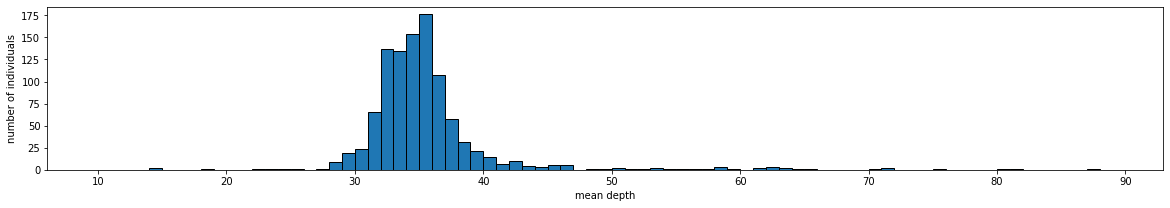

In [50]:
# Make a histogram of individuals and the depth sites
all_fractions = list(indiv_mean_depth.values())

r = range(10, 90, 1)
plt.hist(all_fractions, bins=r, edgecolor='black')
plt.xlabel('mean depth')
plt.ylabel('number of individuals')
plt.show()

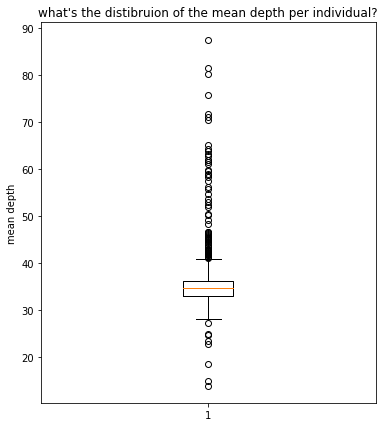

In [47]:
# How does the mean depth look like per individual?

plt.boxplot(indiv_mean_depth.values())
plt.title('what\'s the distibruion of the mean depth per individual?')
plt.ylabel('mean depth')
plt.show()

In [49]:
# How much data is missing per site? 
# Given a site and missingness for all individuals (N = 2082), what's the average for each chr?
# What's the distribution of missingness?

notebook_path = os.path.abspath("preQC_general_analysis.ipynb")
indiv_depth_file_path = os.path.join(os.path.dirname(notebook_path), "data/joint.hg38.PRE-QC.lmiss")

miss_per_chr = {}

# Read the idepth file and extract the IDs and mean depths
with open(indiv_depth_file_path, 'r') as f:
    f.readline()   # skip header (CHR, POS, N_DATA, N_GENOTYPE_FILTERED, N_MISS, F_MISS)
    for line in f:
        line = line.split('\t')
        chr, n_miss = line[0][3:], int(line[4])
        if chr not in miss_per_chr.keys():
            print(chr)
            miss_per_chr[chr] = [n_miss]
        else:
            miss_per_chr[chr].append(n_miss)
            

        

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
X
Y


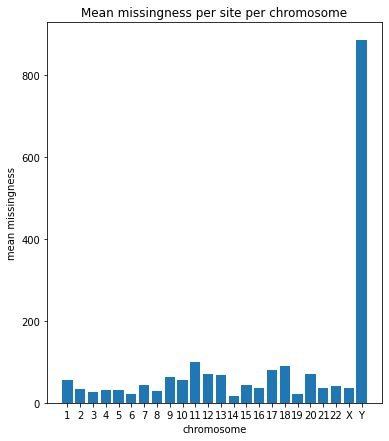

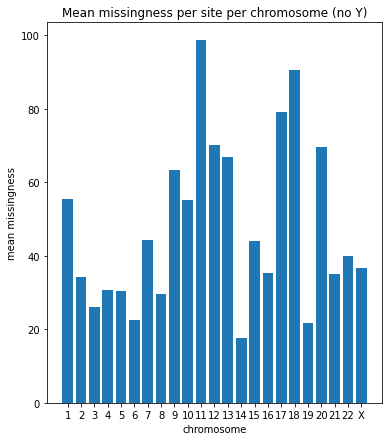

In [62]:
# Plot the mean missingness of each chromosome 

plt.bar(list(miss_per_chr.keys()),[np.mean(miss_per_chr[i]) for i in miss_per_chr.keys()])
plt.title('Mean missingness per site per chromosome')
plt.xlabel('chromosome')
plt.ylabel('mean missingness')
plt.show()

chr_no_y = list(miss_per_chr.keys())[:-1]


plt.bar(chr_no_y,[np.mean(miss_per_chr[i]) for i in chr_no_y])
plt.title('Mean missingness per site per chromosome (no Y)')
plt.xlabel('chromosome')
plt.ylabel('mean missingness')
plt.show()


In [63]:
# There's a lot of variation in the missingness per site. What's the distribution of those numbers per chromosome? 
# How much do they actually vary?

def make_4_cummulant_graphs_missingness(chromosomes):
    """
    Given 4 chromosome labels, create a graph with 4 panels that show
    the distribution of the missingness per chromosome.
    """
    # Show a cumulant graph for the distribution of identity scores
    bins1, fractions1 = make_cummulant(miss_per_chr[chromosomes[0]])
    bins2, fractions2 = make_cummulant(miss_per_chr[chromosomes[1]])
    bins3, fractions3 = make_cummulant(miss_per_chr[chromosomes[2]])
    bins4, fractions4 = make_cummulant(miss_per_chr[chromosomes[3]])

    plt.clf()
    fig = plt.figure()
    gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
    (ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')

    ax1.plot(bins1, fractions1, label='chr '+chromosomes[0], color='blue')
    ax2.plot(bins2, fractions2, label='chr '+chromosomes[1], color='red')
    ax3.plot(bins3, fractions3, label='chr '+chromosomes[2], color='magenta')
    ax4.plot(bins4, fractions4, label='chr '+chromosomes[3], color='green')

    #plt.plot(bins, fractions)
    ax3.set_xlabel('missingness')
    ax3.set_ylabel('fraction of sites')
    fig.legend()
    fig.suptitle('What is the distribution of missingness for different chromosomes?')
    plt.show()

<Figure size 432x504 with 0 Axes>

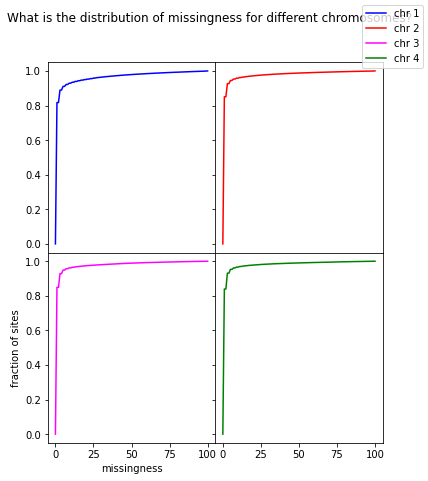

<Figure size 432x504 with 0 Axes>

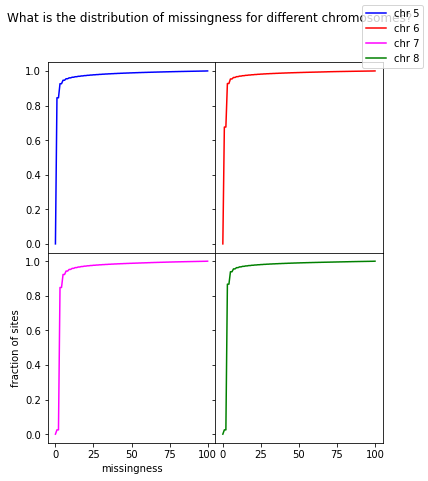

<Figure size 432x504 with 0 Axes>

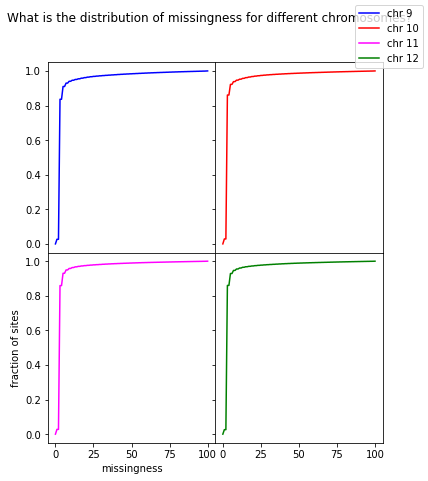

<Figure size 432x504 with 0 Axes>

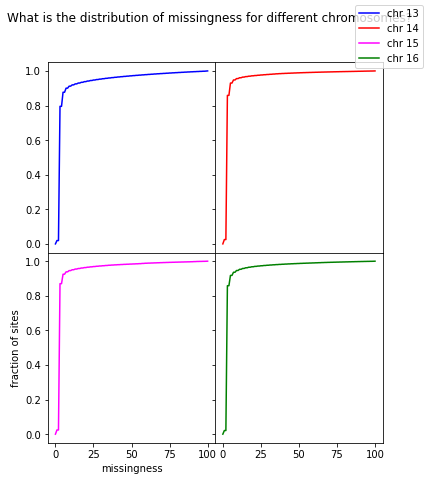

<Figure size 432x504 with 0 Axes>

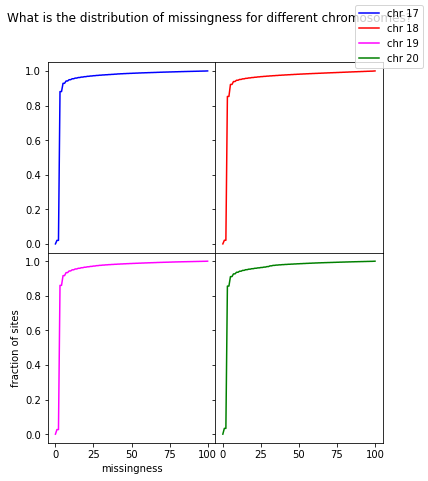

<Figure size 432x504 with 0 Axes>

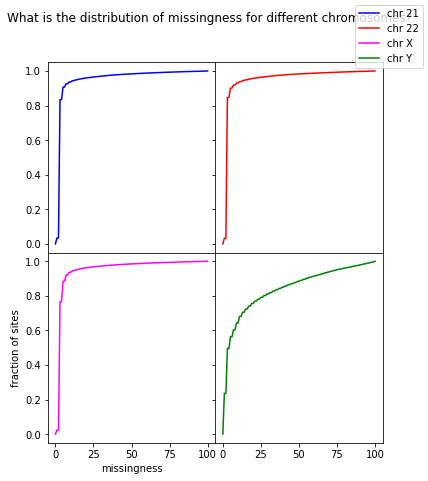

In [65]:
make_4_cummulant_graphs_missingness(['1', '2', '3', '4'])
make_4_cummulant_graphs_missingness(['5', '6', '7', '8'])
make_4_cummulant_graphs_missingness(['9', '10', '11', '12'])
make_4_cummulant_graphs_missingness(['13', '14', '15', '16'])
make_4_cummulant_graphs_missingness(['17', '18', '19', '20'])
make_4_cummulant_graphs_missingness(['21', '22', 'X', 'Y'])

In [26]:
# What about the missingness per individual? How much sites does each individual missing?

notebook_path = os.path.abspath("preQC_general_analysis.ipynb")
indiv_miss_file_path = os.path.join(os.path.dirname(notebook_path), name + ".PRE-QC.imiss")

indiv_missingness = {}
indiv_missingness_f = {}

# Read the imiss file and extract the IDs and N_MISS
with open(indiv_miss_file_path, 'r') as f:
    f.readline()   # skip header
    for line in f:
        line = line.split('\t')
        indiv_missingness[line[0]] = int(line[3])
        indiv_missingness_f[line[0]] = float(line[4])

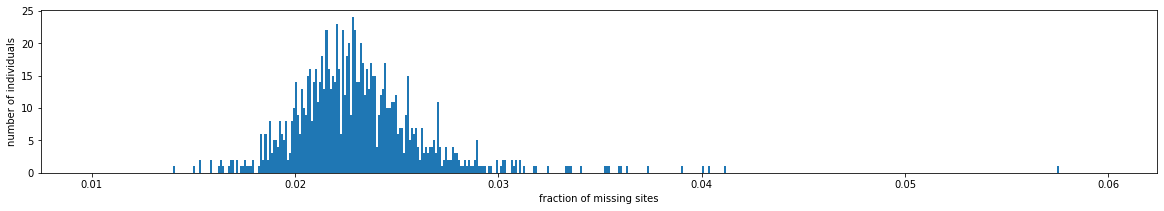

In [34]:
# Make a histogram of individuals and the fraction of missing sites
all_fractions = list(indiv_missingness_f.values())

r = np.arange(0.01, 0.06, 0.0001)
plt.hist(all_fractions, bins=r)
plt.xlabel('fraction of missing sites')
plt.ylabel('number of individuals')
plt.show()

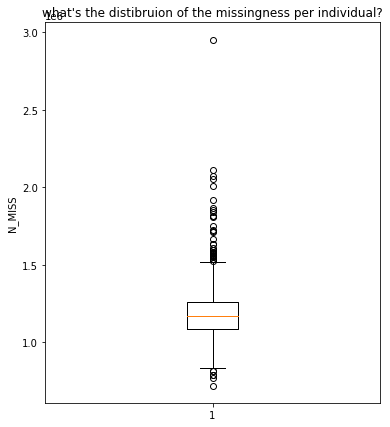

0.588726


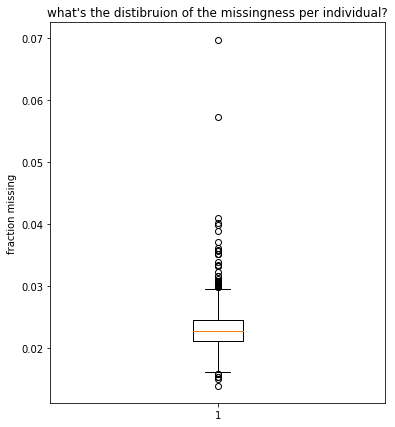

In [93]:
# How does the mean depth look like per individual?

# Get rid of an outlier (~3 MB)
indiv_missingness_vals = np.array(list(indiv_missingness.values()))
indiv_missingness_vals = [i for i in indiv_missingness_vals if i < 3000000]

plt.boxplot(indiv_missingness_vals)
plt.title('what\'s the distibruion of the missingness per individual?')
plt.ylabel('N_MISS')
plt.show()

# Get rid of the outlier at ~60%
indiv_missingness_fractions = np.array(list(indiv_missingness_f.values()))
indiv_missingness_fractions = [i for i in indiv_missingness_fractions if i < 0.58]

# Same thing but with the fractions instead of full numbers
plt.boxplot(indiv_missingness_fractions)
plt.title('what\'s the distibruion of the missingness per individual?')
plt.ylabel('fraction missing')
plt.show()

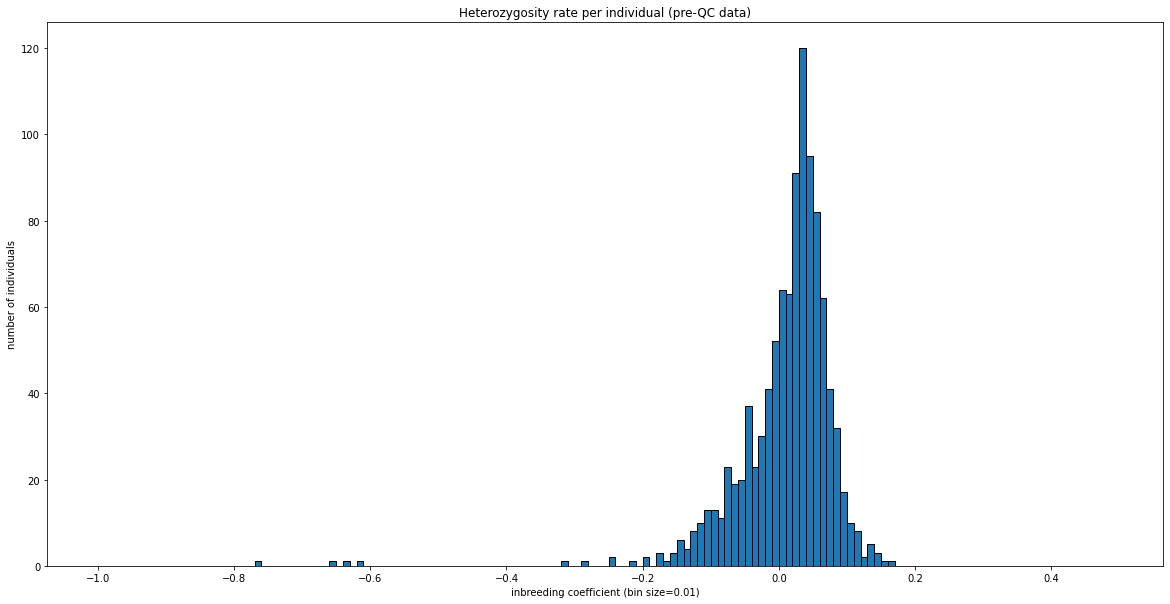

In [15]:
# Look at the measure of heterozygosity, the inbreeding coefficient (F)
notebook_path = os.path.abspath("preQC_general_analysis.ipynb")
indiv_het_path = os.path.join(os.path.dirname(notebook_path), "data/" + name + ".PRE-QC.het")

f_list = []
with open(indiv_het_path, 'r') as f:
    f.readline()   # skip header
    for line in f:
        indiv, f_coeff = line.split('\t')[0], float(line.strip().split('\t')[-1])
        f_list.append(f_coeff)
        
r = np.arange(-1,0.5, 0.01)
plt.hist(f_list, bins=r, edgecolor='black')
plt.xlabel('inbreeding coefficient (bin size=0.01)')
plt.ylabel('number of individuals')
plt.title('Heterozygosity rate per individual (pre-QC data)')
plt.show()


After generating general reports on the whole data, we also want to analyze the sex chromosomes separately. We use PLINK 1.9 software to determine the sex based on the data on the X chromosome (1=male, 2=female). The sex check algorithm flags individuals whom the reported sex in the PED file does not match the estimated sex (from given genomic data). 
The following commands were used to generate the final files.

plink --vcf PREFIX.chrX.vcf --keep-allele-order --vcf-half-call m --make-bed --out PREFIX.chrX.plink

plink --bfile PREFIX.chrX.plink --update-sex $new_sex --make-bed --out PREFIX.chrX.plink.sex

plink --bfile PREFIX.chrX.plink.sex --split-x hg38 --make-bed --out PREFIX.chrX.plink.sex.split-x

plink --bfile PREFIX.chrX.plink.sex.split-x --set-missing-var-ids @:#[b37]\\\\$1,\\\\$2 --make-bed --out PREFIX.chrX.plink.sex.split-x.id

plink --bfile PREFIX.chrX.plink.sex.split-x.id --indep-pairphase 20000 2000 0.5

plink --bfile PREFIX.chrX.plink.sex.split-x.id --extract plink.prune.in --make-bed --out PREFIX.chrX.plink.sex.split-x.id.LD

plink --bfile PREFIX.chrX.plink.sex.split-x.id.LD --check-sex --out PREFIX.chrX.plink.sex.split-x.id.LD.Xsex

At the end of the analysis we have multiple files:

1. joint_colombia_annotated.hg38.chrX.plink.sex.split-x.id.LD.bed

PLINK binary biallelic genotype table, primary representation of genotype calls at biallelic variants. Must be accompanied by .bim and .fam files.


2. joint_colombia_annotated.hg38.chrX.plink.sex.split-x.id.LD.bim

PLINK extended MAP file (each line of the MAP file describes a single marker) , extended variant information file accompanying a .bed binary genotype table.
Info includes: Chromosome code, Variant identifier, Position in morgans, Base-pair coordinate, allele 1, allele 2


3. joint_colombia_annotated.hg38.chrX.plink.sex.split-x.id.LD.fam

PLINK sample information file, information includes: Family ID ('FID'), Within-family ID ('IID'; cannot be '0'), Within-family ID of father , Within-family ID of mother, Sex code, Phenotype value 


4. joint_colombia_annotated.hg38.chrX.plink.sex.split-x.id.LD.Xsex.hh

heterozygous haploid and nonmale Y chromosome call list, produced automatically when the input data contains heterozygous calls where they shouldn't be possible (haploid chromosomes, male X/Y), or there are nonmissing calls for nonmales on the Y chromosome.


5. joint_colombia_annotated.hg38.chrX.plink.sex.split-x.id.LD.Xsex.log


6. joint_colombia_annotated.hg38.chrX.plink.sex.split-x.id.LD.Xsex.sexcheck

X chromosome-based sex validity report, info includes: Family ID, Within-family ID, Sex code in input file, Imputed sex code, Inbreeding coefficient, considering only X chromosome, 

In [9]:
import os

notebook_path = os.path.abspath("preQC_general_analysis.ipynb")
name = 'joint_colombia_annotated.hg38'
sexcheck_file_path = os.path.join(os.path.dirname(notebook_path), "data/chrX/" + name + ".chrX.plink.sex.split-x.id.LD.Xsex.sexcheck")


# Separate samples into XX and XY based on plink algorithms
samples_1, samples_2, samples_problem = [], [], []

with open(sexcheck_file_path, 'r') as f:
    f.readline()     # skip header
    for line in f:
        sample_id, snpsex = line.split()[0], line.split()[3]
        if snpsex == '2':
            samples_2.append(sample_id)
        elif snpsex == '1':
            samples_1.append(sample_id)
        else:
            samples_problem.append(sample_id)
            
            
print('1: %d, 2:%d, problems: %d' %(len(samples_1), len(samples_2), len(samples_problem)))
print('total: %d' %len(samples_1+samples_2+samples_problem))

1: 53, 2:569, problems: 403
total: 1025
